# Notes

For how to calculate area under the curve: 
https://stackoverflow.com/questions/13320262/calculating-the-area-under-a-curve-given-a-set-of-coordinates-without-knowing-t


other ideas for characterizing data: 

-Fourier Transform 

-Positive vs Negative area under curve (calculate baseline value, then then spikes beneath it are negative area, e.g. trough area

-Peak heights and distances 

-sincNet: probably not that effective given that its setup for human voice, not ECG 

-wavelet transforms: 
    -likely to be better than fourier transform for non-sinusoidal shape 
    -mostly  used in sincnet? 
    -Droplet Wave transform may be very useful
    
-Spectrum Analysis: Seems to not be that great according to the first paper below, maybe not worth it


Filtering: 
    -would likely help if needed, but I think the dataset has already had soome filtering applied 
    -would need to run some computations for our specific dataset to determine frequencies to include/exclude in a band-pass filter 


TERMA 
    -would need to know the approximate cycle time between each heartbeat as well as a lot of other parameters
    -we may just be able to use the mdpi calculated frequencies for the TERMA approach and assume they're pretty good, given that it's working to solve the exact same problem 
    -setting up TERMA to pick out features shouldn't be too crazy but is definitely a good amount of work on its own 
    -according to study below, is simpler than other wave detectors and gets better results on most things 
   -requires good signal to noise ratio (SNR)
    
    
    
    
OTHER WAVE DETECTORS: a whole bunch are listed for comparison in the testing results section of the mdpi study below



# Studies 

softmax, ReLU(Leaky ReLU), CNN, SincNet, mentions wavelet transforms
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8469424/

goes into the different aspects of the waves themselves more: 
https://www.nature.com/articles/s41598-021-97118-5 

Two event-related moving averages (TERMA - method for detecting R waves and other important ECG characteristics): 
https://www.mdpi.com/2079-6374/6/4/55/htm

A comparison of a whole bunch of different models 
https://arxiv.org/pdf/2004.13701.pdf


    
    


In [7]:
!pip install wfdb


In [2]:
##SAMPLE CODE FROM DATASET INFO PAGE - IMPORTS DATA AND SPLITS INTO TEST/TRAIN SET

import pandas as pd
import numpy as np
import wfdb
import ast

sampling_rate = 100
def load_raw_data(df, sampling_rate, path):
    #choose 100 for the 100hz file (500mb) and 500hz (2.7gB)
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

path = r"C:\Users\scrav\Documents\ECE 493R\FInal Project - EKG\PBT-XL Extracted\\"


# load and convert annotation data
Y = pd.read_csv(r"C:\Users\scrav\Documents\ECE 493R\FInal Project - EKG\PBT-XL Extracted\ptbxl_database.csv", index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

# Split data into train and test
test_fold = 10
# Train
X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

(19634, 1000, 12)
<class 'pandas.core.frame.DataFrame'>
        patient_id   age  sex  height  weight  nurse  site      device  \
ecg_id                                                                   
2308       10649.0  45.0    1     NaN    72.0    0.0   0.0   CS-12   E   
2309        1134.0  38.0    1   170.0    81.0    4.0   1.0  AT-6 C 5.5   
2310        1712.0  76.0    1   150.0    57.0   11.0   1.0  AT-6 C 5.5   
2311        4897.0  81.0    0   162.0    68.0   10.0   1.0  AT-6 C 5.5   
2312        7397.0  43.0    0   183.0    92.0    9.0   1.0  AT-6     6   
...            ...   ...  ...     ...     ...    ...   ...         ...   
21832       7954.0  63.0    0     NaN     NaN    1.0   2.0  AT-60    3   
21833      17180.0  67.0    1     NaN     NaN    1.0   2.0  AT-60    3   
21834      20703.0  93.0    0     NaN     NaN    1.0   2.0  AT-60    3   
21835      19311.0  59.0    1     NaN     NaN    1.0   2.0  AT-60    3   
21836       8873.0  64.0    1     NaN     NaN    1.0   2

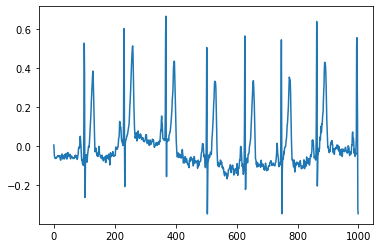

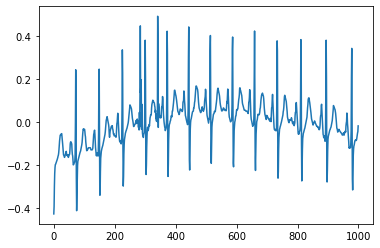

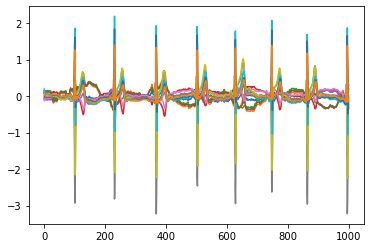

In [52]:
import matplotlib.pyplot as plt

print(X_train.shape)
plt.plot(X[1,:,0])
plt.figure()
plt.plot(X[2308,:,1])
plt.figure()
plt.plot(X[1])
print(type(Y))
print(Y[2307:-1])

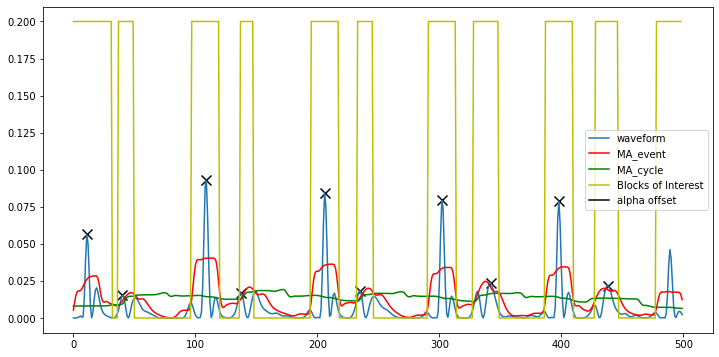

In [163]:
import matplotlib.pyplot as plt
from scipy import signal


def MA(y, W1):
    ma =[]
    for n in range(len(y)):
        sum = y[n]

        for i in range(1,W1):
            upper = (n + ((W1 - i)))
            lower = (n - (W1 - i))
            if  upper > 0 and upper < len(y):
                sum += y[upper]
            if lower > 0 and lower < len(y):
                sum += y[lower]

        sum = sum / W1
        ma.append(sum)
    return ma
            

def TERMA_Detector(Sig, F1, F2, W1, W2, B):
    
    #filter input vector with fourth order butterworth
    #todo: generate butterworth filter for entire dataset instead of doingit for each vector
    Wn = [F1, F2]
    sos = signal.butter(3, Wn, fs=100, btype='bandpass', output='sos')
    x = signal.sosfilt(sos, Sig)


    #square input vector to emphasize extremes
    y = x**2
    
    #generate moving average window for event 
    MA_event = MA(y, W1)
    MA_cycle = MA(y, W2)
    
    
    #calculate mean for sample
    z = np.mean(y)
#     print(z)
    
    #calculate alpha offset value for threshold
    #alpha offset is designed to reduce effects of low SNR
    alpha = B*z
    
    
    #calculate threshold 1 from mean, alpha, and beta threshold
    #alpha threshold makes threshold too high for some reason?? maybe because 
    # noise is already filtered out? 
    THR1 = MA_cycle + alpha
    #print(THR1.shape)
    BlocksOfInterest = []
    for n in range(1,len(MA_event)):
        if (MA_event[n] > THR1[n]):
            BlocksOfInterest.append(.2)
        else:
            BlocksOfInterest.append(0)
        
        
    #calculate start and end offsets of blocks using simple state machine
    Blocks = []
    state = 0
    for n in range(1, len(BlocksOfInterest)):
        if state == 0:
            if (BlocksOfInterest[n] > 0):
                start = n
                state = 1
        if state == 1:
            if (BlocksOfInterest[n] == 0):
                end = n
                Blocks.append([start, end])
                state = 0
    
    THR2 = W1
    peaksx = []
    peaksy = []
    #extract index of max for each block, add to list
    for block in Blocks:
#         print(block[1], block[0])
        blockWidth = (block[1] - block[0])
        if (blockWidth >= THR2 ):
            sublist = y[block[0]:block[1]]
            peaksx.append([np.argmax(sublist) + block[0]])
            peaksy.append(np.max(sublist))
    
#     print(peaksx)
    
#     print(Blocks)
    
#     plt.plot(Sig)
#     plt.figure()
#     plt.plot(x)
    plt.figure(figsize=(12, 6))
    plt.plot(y, label = 'waveform')
    plt.plot(MA_event, color='r', label='MA_event')
    plt.plot(MA_cycle, color='g', label='MA_cycle')
    plt.plot(BlocksOfInterest, color='y', label='Blocks of Interest')
    plt.scatter(peaksx, peaksy,s=100, marker="x", color='k')
    plt.plot(alpha, color='k', label = "alpha offset")
    plt.legend()


vect = X[2,:,0]
TERMA_Detector(vect[0:500],.5,8,11,67,.02)